## 0. 패키지 및 라이브러리, API 키 설정 (Package Installation & API Key Setup)

In [ ]:
# 필요한 패키지 설치
! pip install openai
! pip install pinecone
! pip install langchain
! pip install spotipy
! pip install langchain_community
! pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.8/419.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting u

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from tqdm import tqdm
import time
import os
import re
import json
import warnings
warnings.filterwarnings('ignore')

from openai import OpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import SystemMessage, HumanMessage
from langchain.chat_models import ChatOpenAI

from pinecone import Pinecone
from langchain.vectorstores import Pinecone as PineconeVectorStore

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# API KEY 설정
MY_PINECONE_API_KEY = "MY_PINECONE_API_KEY"
MY_OPENAI_API_KEY = "MY_OPENAI_API_KEY"
MY_SPOTIFY_CLIENT_ID='MY_SPOTIFY_CLIENT_ID'
MY_SPOTIFY_CLIENT_SECRET='MY_SPOTIFY_CLIENT_SECRET'

## 1. 데이터 로드 (Load Data)

In [ ]:
# 데이터 파일 경로 지정
file_path = 'file_path'

# 데이터 로드
df = pd.read_csv(file_path, sep=',')

# 임베딩 벡터 문자열을 리스트로 변환
df['Embeddings'] = df['Embeddings'].apply(ast.literal_eval)

# 임베딩 벡터 리스트를 가져옵니다.
embeddings = df['Embeddings'].tolist()

# 첫 번째 임베딩 벡터의 차원 확인
embedding_dimension = len(embeddings[0])
print(f"Embedding Dimension: {embedding_dimension}")

# 데이터 확인
df.head()

Mounted at /content/drive
Embedding Dimension: 3072


,Unnamed: 0,artists,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,description,Embeddings
0,0,Chord Overstreet,Hold On,0.618,0.443,2,-9.681,1,0.0526,0.469,0.00000,0.0829,0.167,119.949,acoustic,"The theme of Chord Overstreet's ""Hold On"" revo...","[-0.03256285935640335, -0.014628749340772629, ..."
1,1,Zack Tabudlo,Pano,0.375,0.457,3,-7.018,1,0.0315,0.868,0.01450,0.1910,0.415,174.839,acoustic,"The theme of Zack Tabudlo's ""Pano"" revolves ar...","[-0.05376829579472542, -0.0033851894550025463,..."
2,2,Jason Mraz;Colbie Caillat,Lucky,0.625,0.414,0,-8.700,1,0.0369,0.294,0.00000,0.1510,0.669,130.088,acoustic,The theme of Jason Mraz and Colbie Caillat's L...,"[-0.022357532754540443, -0.022306429222226143,..."
3,3,Zack Tabudlo,Give Me Your Forever,0.627,0.363,8,-8.127,1,0.0291,0.279,0.00000,0.0928,0.301,99.905,acoustic,"The theme of Zack Tabudlo's ""Give Me Your Fore...","[-0.0288945734500885, -0.030793359503149986, -..."
4,4,Zack Tabudlo,Asan Ka Na Ba,0.676,0.768,5,-5.695,0,0.0294,0.149,0.00147,0.3450,0.493,105.999,acoustic,"The theme of Zack Tabudlo's ""Asan Ka Na Ba"" re...","[-0.01884930022060871, -0.011930854991078377, ..."


## 2. LangChain과 OpenAI 모델 설정 (LangChain & OpenAI Model Setup)

In [ ]:
# OpenAI 클라이언트 인스턴스 생성
client = OpenAI(
    api_key=MY_OPENAI_API_KEY
)

# LLM 인스턴스 생성
llm = ChatOpenAI(
    openai_api_key=MY_OPENAI_API_KEY,
    model_name="gpt-4o",
    temperature=0.7
)

# Embeddings 인스턴스 생성
embed_model = OpenAIEmbeddings(
    openai_api_key=MY_OPENAI_API_KEY,
    model="text-embedding-3-large"
)

<ipython-input-4-8da6bd0d91e1>:7: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
<ipython-input-4-8da6bd0d91e1>:14: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embed_model = OpenAIEmbeddings(


## 3. Pinecone 벡터 스토어 설정 (Pinecone Vector Store Setup)

In [ ]:
# Pinecone 초기화
pc = Pinecone(
    api_key=MY_PINECONE_API_KEY
)

# 인덱스 이름 설정
index_name = 'music-recommendation'

# 인덱스에 연결
index = pc.Index(index_name)

# 벡터 스토어 객체 생성
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embed_model.embed_query,
    text_key='Description'
)

<ipython-input-5-b11cafa9c022>:13: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-pinecone package and should be used instead. To use it run `pip install -U :class:`~langchain-pinecone` and import as `from :class:`~langchain_pinecone import Pinecone``.
  vectorstore = PineconeVectorStore(


## 4. 사용자 정보 데이터 생성 (User Data Generation)

- 실사용자 데이터로 변경

In [ ]:
# 사용자 정보 딕셔너리 생성
user_info = {
    'born': 1999,
    'preferred_genres': ['Pop', 'Acoustic'],
    'favorite_artists': ['Ed Sheeran', 'Taylor Swift'],
    'listened_tracks': ['Shape of You', 'Blank Space']
}

# 사용자 정보를 문자열로 변환
user_info_str = f"Born: {user_info['born']}\n" \
                f"Preferred Genres: {', '.join(user_info['preferred_genres'])}\n" \
                f"Favorite Artists: {', '.join(user_info['favorite_artists'])}\n" \
                f"Listened Tracks: {', '.join(user_info['listened_tracks'])}"

print(user_info_str)

Born: 1999
Preferred Genres: Pop, Acoustic
Favorite Artists: Ed Sheeran, Taylor Swift
Listened Tracks: Shape of You, Blank Space


## 5. 유사도 검색 및 결과 확인 (Similarity Search & Results)

- 예시 쿼리
    - Please recommend a sad breakup song to comfort me when I get dumped after confessing
    - 우울할 때: Please recommend a song to listen to when you're depressed and sad
    - 신나는 바이브: Please recommend some upbeat and energizing songs to boost my mood

In [ ]:
# 사용자 쿼리 설정
query = "Please recommend some upbeat and energizing songs to boost my mood"

# 유사도 검색 수행
results = vectorstore.similarity_search(query, k=10)

# 결과 출력
for idx, result in enumerate(results):
    metadata = result.metadata
    print(f"Song {idx+1}:")
    print(f"Track Name: {metadata.get('Track Name') or metadata.get('track_name')}")
    print(f"Artists: {metadata.get('Artists') or metadata.get('artists')}")
    print(f"Genre: {metadata.get('Genre') or metadata.get('genre')}")
    print(f"Danceability: {metadata.get('Danceability') or metadata.get('danceability')}")
    print(f"Energy: {metadata.get('Energy') or metadata.get('energy')}")
    print(f"Key: {metadata.get('Key') or metadata.get('key')}")
    print(f"Loudness: {metadata.get('Loudness') or metadata.get('loudness')}")
    print(f"Mode: {metadata.get('Mode') or metadata.get('mode')}")
    print(f"Speechiness: {metadata.get('Speechiness') or metadata.get('speechiness')}")
    print(f"Acousticness: {metadata.get('Acousticness') or metadata.get('acousticness')}")
    print(f"Instrumentalness: {metadata.get('Instrumentalness') or metadata.get('instrumentalness')}")
    print(f"Liveness: {metadata.get('Liveness') or metadata.get('liveness')}")
    print(f"Valence: {metadata.get('Valence') or metadata.get('valence')}")
    print(f"Tempo: {metadata.get('Tempo') or metadata.get('tempo')}")
    print(f"Description: {result.page_content}\n")

Song 1:
Track Name: Shake and Move
Artists: Patty Shukla
Genre: party
Danceability: 0.795
Energy: 0.511
Key: 7.0
Loudness: -8.577
Mode: 1.0
Speechiness: 0.0415
Acousticness: 0.298
Instrumentalness: None
Liveness: 0.149
Valence: 0.113
Tempo: 119.908
Description: The theme of Patty Shukla's Shake and Move is a joyful celebration of movement and playfulness, encouraging listeners, particularly children, to engage in fun physical activities. The lyrics promote a variety of simple, interactive movements such as wiggling fingers, shaking hands, and patting knees, creating an atmosphere of energy and excitement. The repetitive nature of the lyrics and the call-and-response format foster a sense of participation and community. The mood of the song is upbeat, lively, and cheerful, making it perfect for parties or playful environments. Overall, the song embodies a spirit of fun and encourages listeners to let loose and enjoy moving their bodies.

Song 2:
Track Name: Rise Up (feat. Vamero)
Artist

## 6. 답변 생성을 위한 프롬프트 보강 및 하이퍼파라미터 생성 (Prompt Augmentation & Hyperparameter Generation)

In [ ]:
def augment_prompt(query: str, results, user_info_str):
    source_knowledge = "\n\n".join([
        f"Song {idx+1}:\n"
        f"Track Name: {res.metadata.get('Track Name') or res.metadata.get('track_name')}\n"
        f"Artists: {res.metadata.get('Artists') or res.metadata.get('artists')}\n"
        f"Genre: {res.metadata.get('Genre') or res.metadata.get('genre')}\n"
        f"Danceability: {res.metadata.get('Danceability') or res.metadata.get('danceability')}\n"
        f"Energy: {res.metadata.get('Energy') or res.metadata.get('energy')}\n"
        f"Key: {res.metadata.get('Key') or res.metadata.get('key')}\n"
        f"Loudness: {res.metadata.get('Loudness') or res.metadata.get('loudness')}\n"
        f"Mode: {res.metadata.get('Mode') or res.metadata.get('mode')}\n"
        f"Speechiness: {res.metadata.get('Speechiness') or res.metadata.get('speechiness')}\n"
        f"Acousticness: {res.metadata.get('Acousticness') or res.metadata.get('acousticness')}\n"
        f"Instrumentalness: {res.metadata.get('Instrumentalness') or res.metadata.get('instrumentalness')}\n"
        f"Liveness: {res.metadata.get('Liveness') or res.metadata.get('liveness')}\n"
        f"Valence: {res.metadata.get('Valence') or res.metadata.get('valence')}\n"
        f"Tempo: {res.metadata.get('Tempo') or res.metadata.get('tempo')}\n"
        f"Description: {res.page_content}"
        for idx, res in enumerate(results)
    ])

    # Spotify API parameter definitions
    hyperparameter_definitions = """
    Spotify API Hyperparameter Definitions:
    - `seed_genres`: A list of genres relevant to the user's query and preferences. Up to 5 seed values may be provided.
    - `min_acousticness`, `max_acousticness`, `target_acousticness`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target acousticness of the tracks.
    - `min_danceability`, `max_danceability`, `target_danceability`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target danceability.
    - `min_energy`, `max_energy`, `target_energy`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target energy.
    - `min_instrumentalness`, `max_instrumentalness`, `target_instrumentalness`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target instrumentalness.
    - `min_liveness`, `max_liveness`, `target_liveness`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target liveness.
    - `min_loudness`, `max_loudness`, `target_loudness`: Numeric values specifying the minimum, maximum, and target loudness in decibels (dB). Values typically range between -60 and 0 dB.
    - `min_mode`, `max_mode`, `target_mode`: Integer values 0 or 1 specifying the modality (minor or major) of the tracks.
    - `min_speechiness`, `max_speechiness`, `target_speechiness`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target speechiness.
    - `min_tempo`, `max_tempo`, `target_tempo`: Numeric values specifying the minimum, maximum, and target tempo in beats per minute (BPM).
    - `min_valence`, `max_valence`, `target_valence`: Numeric values between 0.0 and 1.0 specifying the minimum, maximum, and target valence.
    - Other Parameters: Similar patterns apply for other audio features like `key`.
    Note: Only include parameters that are relevant and based on significant trends in the provided song options. Use values within the specified ranges.
    """
    augmented_prompt = f"""You are an assistant that generates hyperparameters for a song recommendation engine.

---

Instructions for Generating Hyperparameters:

**Instructions for generating `target_features`:**
- Analyze Trends: Examine the provided song options to identify consistent trends or values in audio features.
- Set Appropriate Parameters: Based on these trends, set the corresponding Spotify API parameters (`min_*`, `max_*`, `target_*`).
  - For example, if most songs have a `danceability` above 0.7, you might set `min_danceability` to 0.7.
  - If the `energy` values cluster around 0.6, you might set `target_energy` to 0.6.

**Instructions for generating `seed_genres`:**
- Select Relevant Seed Genres:
  - Identify genres from the song options and the user's query that match the user's preferences or the mood described.
  - Include up to 5 genres that are most relevant.
  - For example, if the user's query mentions "calm and emotional rainy day," include genres like "acoustic" or "singer-songwriter".

- Formatting Guidelines:
  - Do not provide any explanations or additional text; output only the hyperparameters.

Based on the user's query, the provided song options, and the user's history data, generate the hyperparameters in the following format:
"seed_genres": [...], "target_features": {{"feature_name": value, ...}}


User Query:
{query}

User Info:
{user_info_str}

Here are some song options:
{source_knowledge}

Please generate the hyperparameters accordingly.
"""


    # **여기에서 augmented_prompt를 반환해야 합니다**
    return augmented_prompt

# Generate the augmented prompt
prompt = augment_prompt(query, results, user_info_str)

messages = [
    SystemMessage(content="You are an assistant that generates hyperparameters for a song recommendation engine."),
    HumanMessage(content=prompt)
]

# LLM을 사용하여 응답 생성
response = llm(messages)

# 응답 출력
print("Generated Hyperparameters:")
print(response.content)

Generated Hyperparameters:
"seed_genres": ["pop", "party", "edm", "dance", "k-pop"], "target_features": {"min_danceability": 0.7, "target_energy": 0.9, "min_valence": 0.5}


In [ ]:
# LLM's response content
content1 = response.content.strip()

# Remove any code block markers like ```json or ```
content1 = re.sub(r'^```[a-z]*\n', '', content1)
content1 = re.sub(r'\n```$', '', content1)
content1 = content1.strip()

# Ensure the content is enclosed within curly braces {}
if not content1.startswith('{'):
    content1 = '{' + content1
if not content1.endswith('}'):
    content1 = content1 + '}'

# Count the number of opening and closing braces
open_braces = content1.count('{')
close_braces = content1.count('}')

# Add missing closing braces
while close_braces < open_braces:
    content1 += '}'
    close_braces += 1

# Now, content1 should contain valid JSON
print("JSON content:")
print(content1)

# Parse the JSON content
try:
    hyperparameters = json.loads(content1)
    seed_genres = hyperparameters.get('seed_genres', [])
    target_features = hyperparameters.get('target_features', {})
    print("\nParsed hyperparameters:")
    print(f"seed_genres: {seed_genres}")
    print(f"target_features: {target_features}")
except json.JSONDecodeError as e:
    print(f"Error parsing hyperparameters: {e}")

JSON content:
{"seed_genres": ["pop", "party", "edm", "dance", "k-pop"], "target_features": {"min_danceability": 0.7, "target_energy": 0.9, "min_valence": 0.5}}

Parsed hyperparameters:
seed_genres: ['pop', 'party', 'edm', 'dance', 'k-pop']
target_features: {'min_danceability': 0.7, 'target_energy': 0.9, 'min_valence': 0.5}


## 7. 추천 시스템 엔진 (Recommendation System Engine)

    """
    Spotify API를 사용하여 추천 트랙을 가져옵니다.

    :param seed_artists: 추천의 기준이 될 아티스트 ID 리스트
    :param seed_genres: 추천의 기준이 될 장르 리스트
    :param seed_tracks: 추천의 기준이 될 트랙 ID 리스트
    :param target_features: 음악 특징 (예: {'danceability': 0.8, 'energy': 0.7})
    :param limit: 추천받을 트랙의 개수 (기본값: 10)
    :return: 추천 트랙 리스트
    """

In [ ]:
# Spotipy 클라이언트 설정
client_credentials_manager = SpotifyClientCredentials(client_id=MY_SPOTIFY_CLIENT_ID, client_secret=MY_SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def get_recommendations(seed_artists=None, seed_genres=None, seed_tracks=None, target_features=None, limit=10):
    recommendations = sp.recommendations(seed_artists=seed_artists,
                                         seed_genres=seed_genres,
                                         seed_tracks=seed_tracks,
                                         limit=limit,
                                         **(target_features or {}))

    # 데이터프레임에 저장할 데이터를 리스트로 준비
    data = []

    for i, track in enumerate(recommendations['tracks']):
        # 기본 트랙 정보 수집
        track_data = {
            "track_name": track['name'],
            "artists": ', '.join([artist['name'] for artist in track['artists']]),
            "preview_url": track['preview_url'],
            "external_urls": track['external_urls']['spotify'],
            "track_id": track['id']
        }

        # 주요 아티스트의 ID 가져오기
        main_artist_id = track['artists'][0]['id'] if track['artists'] else None
        genre_info = "N/A"  # 기본값으로 'N/A' 설정

        # 주요 아티스트의 장르 정보 가져오기
        if main_artist_id:
            artist_info = sp.artist(main_artist_id)
            genre_info = ', '.join(artist_info.get('genres', []))

        # 장르 정보를 트랙 데이터에 추가
        track_data['genre'] = genre_info

        # 트랙 정보 출력
        print(f"{i + 1}. {track['name']} - {track_data['artists']}")
        print(f"   Genre: {track_data['genre']}")
        print(f"   Preview: {track_data['preview_url']}")
        print(f"   Spotify URL: {track_data['external_urls']}")
        print(f"   Spotify ID: {track_data['track_id']}")

        # Audio Features 조회
        audio_features = sp.audio_features(track['id'])[0]

        # Audio Features와 기타 정보 추가 및 출력
        if audio_features:
            features = {
                "danceability": audio_features.get('danceability'),
                "energy": audio_features.get('energy'),
                "key": audio_features.get('key'),
                "loudness": audio_features.get('loudness'),
                "mode": audio_features.get('mode'),
                "speechiness": audio_features.get('speechiness'),
                "acousticness": audio_features.get('acousticness'),
                "instrumentalness": audio_features.get('instrumentalness'),
                "liveness": audio_features.get('liveness'),
                "valence": audio_features.get('valence'),
                "tempo": audio_features.get('tempo'),
                "type": audio_features.get('type'),
                "id": audio_features.get('id'),
                "uri": audio_features.get('uri'),
                "track_href": audio_features.get('track_href'),
                "analysis_url": audio_features.get('analysis_url'),
                "duration_ms": audio_features.get('duration_ms'),
                "time_signature": audio_features.get('time_signature')
            }
            track_data.update(features)

            print("   Audio Features:")
            for feature, value in features.items():
                print(f"      {feature}: {value}")
            print("\n")

        # 수집된 데이터를 리스트에 추가
        data.append(track_data)

    # 데이터프레임 생성
    df = pd.DataFrame(data)
    return df

# LLM의 응답 내용
hyperparameters_str = content1.strip()

# 문자열을 안전하게 파싱하여 딕셔너리로 변환
try:
    hyperparameters = ast.literal_eval(hyperparameters_str)
except Exception as e:
    print(f"Error parsing hyperparameters: {e}")
    hyperparameters = {}

# 하이퍼파라미터 추출
seed_genres = hyperparameters.get('seed_genres', [])
target_features = hyperparameters.get('target_features', {})

# 추천 함수 호출
recommendation_df = get_recommendations(
    seed_genres=seed_genres,
    target_features=target_features,
    limit=30
)

1. All I Ask of You (feat. Pennybirdrabbit) - Skrillex, pennybirdrabbit
   Genre: brostep, complextro, edm, electro, pop dance
   Preview: https://p.scdn.co/mp3-preview/e3851d81a374b45f382181e89de885d05ec50490?cid=5217e424fcbf43f1bb6c280ef4868583
   Spotify URL: https://open.spotify.com/track/1A3XPibNuMPTbTWlPgRfTD
   Spotify ID: 1A3XPibNuMPTbTWlPgRfTD
   Audio Features:
      danceability: 0.774
      energy: 0.909
      key: 9
      loudness: -2.89
      mode: 0
      speechiness: 0.0365
      acousticness: 0.0173
      instrumentalness: 0.121
      liveness: 0.0739
      valence: 0.696
      tempo: 126.977
      type: audio_features
      id: 1A3XPibNuMPTbTWlPgRfTD
      uri: spotify:track:1A3XPibNuMPTbTWlPgRfTD
      track_href: https://api.spotify.com/v1/tracks/1A3XPibNuMPTbTWlPgRfTD
      analysis_url: https://api.spotify.com/v1/audio-analysis/1A3XPibNuMPTbTWlPgRfTD
      duration_ms: 340341
      time_signature: 4


2. 1, 2, 3 (feat. Jason Derulo & De La Ghetto) - Sofía Reyes, J

## 8. 추천 결과에 대한 인사이트

In [ ]:
# 시각화할 feature 리스트
columns_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo']

recommendation_df[columns_num].describe().transpose().sort_index()

,count,mean,std,min,25%,50%,75%,max
acousticness,30.0,0.086186,0.093164,0.000972,0.025575,0.060700,0.095225,0.444
danceability,30.0,0.752233,0.039599,0.706000,0.714500,0.743000,0.780250,0.834
energy,30.0,0.889467,0.023346,0.849000,0.873750,0.890000,0.907750,0.938
instrumentalness,30.0,0.027278,0.123191,0.000000,0.000000,0.000001,0.000141,0.669
key,30.0,4.566667,3.420862,0.000000,1.000000,4.500000,8.000000,10.000
liveness,30.0,0.179203,0.124087,0.046500,0.082450,0.140500,0.251250,0.580
loudness,30.0,-3.766100,1.440152,-8.345000,-4.311250,-3.350500,-2.900500,-1.850
mode,30.0,0.633333,0.490133,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,30.0,0.095307,0.075301,0.028900,0.051925,0.064150,0.108250,0.338
tempo,30.0,123.244367,15.691849,91.030000,112.532000,126.046500,128.015500,155.943


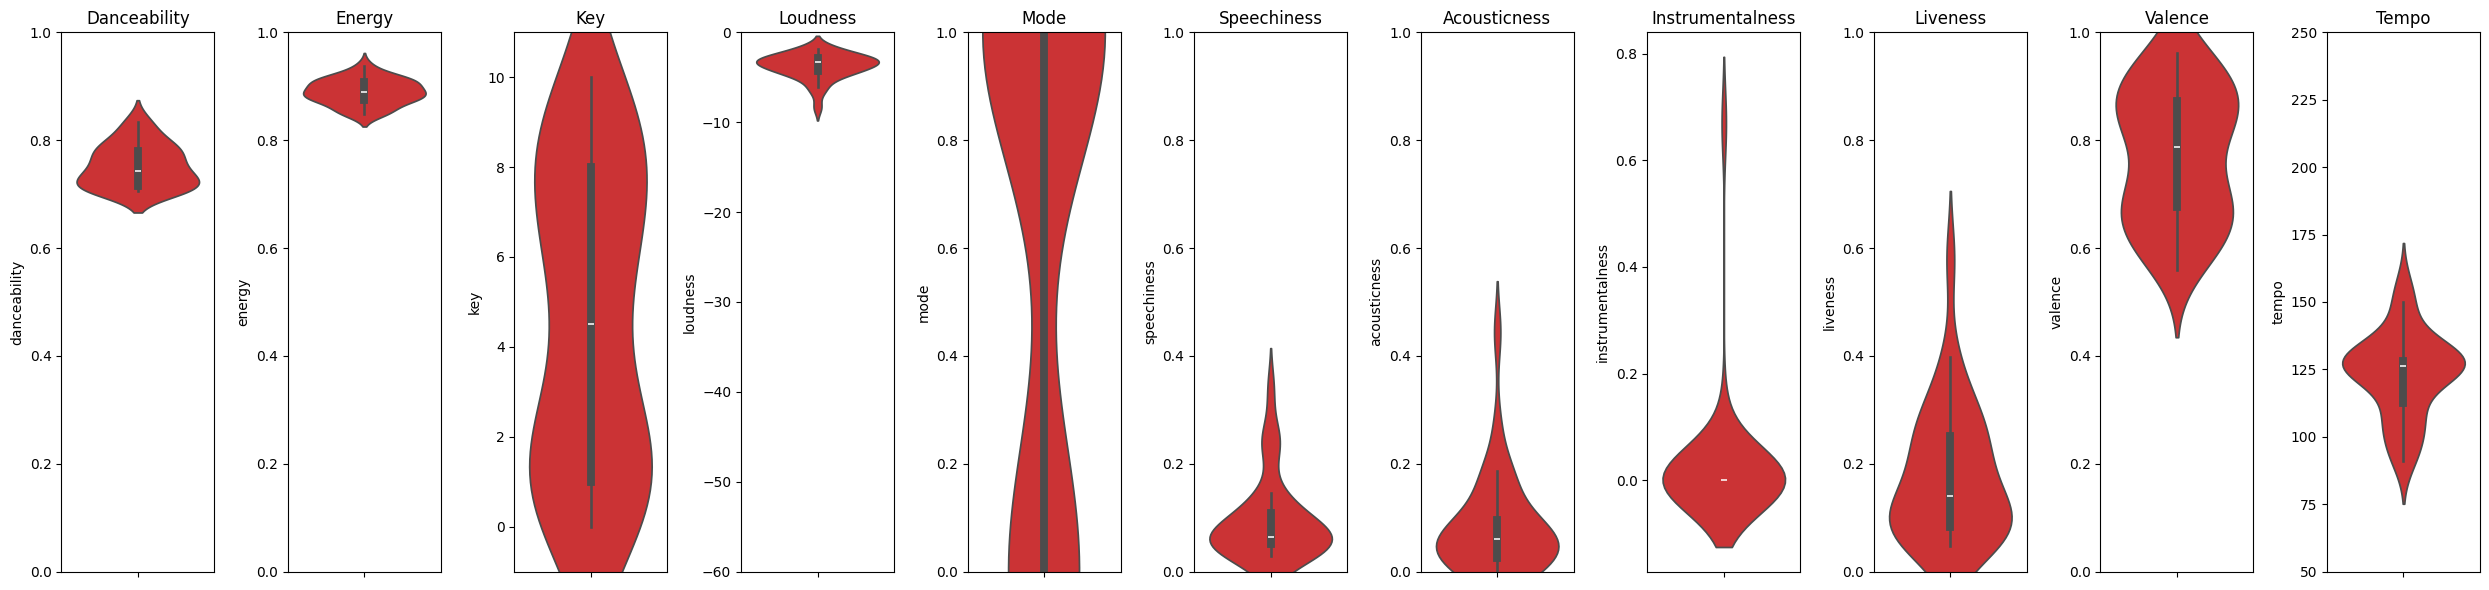

In [ ]:
# 각 feature에 대한 바이올린 플롯 생성
plt.figure(figsize=(25, 6))

# y축 범위가 고정될 feature와 그 범위를 딕셔너리로 정의
features_with_custom_ylim = {
    'danceability': (0, 1),
    'energy': (0, 1),
    'speechiness': (0, 1),
    'acousticness': (0, 1),
    'liveness': (0, 1),
    'valence': (0, 1),
    'mode': (0, 1),
    'key': (-1, 11),
    'loudness': (-60, 0),
    'tempo': (50, 250)
}

for i, feature in enumerate(columns_num, 1):
    plt.subplot(1, len(columns_num), i)
    sns.violinplot(data=recommendation_df, y=feature, palette="Set1") # Set2, Blues, Set1
    plt.title(f'{feature.capitalize()}')
    plt.xlabel('')
    plt.ylabel(feature)

    # y축 범위가 정의된 경우 설정
    if feature in features_with_custom_ylim:
        plt.ylim(features_with_custom_ylim[feature])

plt.tight_layout()
plt.show()

In [ ]:
# 데이터저장
recommendation_df.to_csv('[개인연구]비교데이터_신날때_추천30개_RAG있음.csv', index=False)